In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loaded 1000 images. Polyp: 1000, Non-Polyp: 0
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 609s 12s/step - accuracy: 0.8689 - loss: 0.2014 - val_accuracy: 1.0000 - val_loss: 1.6641e-04
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 610s 11s/step - accuracy: 1.0000 - loss: 1.7041e-04 - val_accuracy: 1.0000 - val_loss: 5.0191e-05
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 565s 11s/step - accuracy: 1.0000 - loss: 7.9216e-05 - val_accuracy: 1.0000 - val_loss: 2.4184e-05
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 648s 12s/step - accuracy: 1.0000 - loss: 2.8163e-05 - val_accuracy: 1.0000 - val_loss: 1.5325e-05
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 594s 11s/step - accuracy: 1.0000 - loss: 1.9308e-05 - val_accuracy: 1.0000 - val_loss: 1.0182e-05
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 590s 12s/step - accuracy: 1.0000 - loss: 1.5599e-05 - val_accuracy: 1.0000 - val_loss: 7.2178e-06
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 626s 12s/step - accuracy: 1.0000 - loss: 1.0788e-05

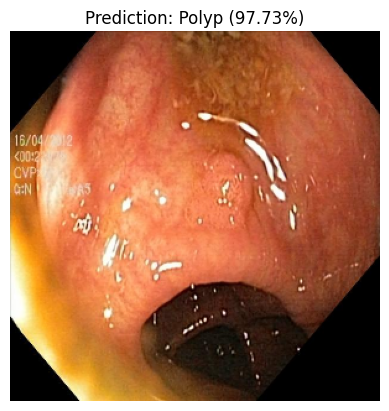

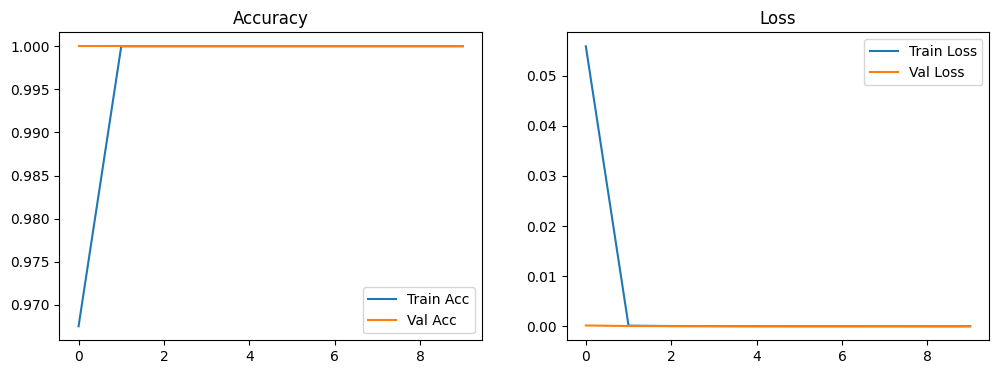

In [3]:
class PolypClassifier:
    def __init__(self, input_shape=(299, 299, 3), num_classes=2):
        base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(256, activation='relu')(x)
        predictions = Dense(num_classes, activation='softmax')(x)

        self.model = Model(inputs=base_model.input, outputs=predictions)
        for layer in base_model.layers:
            layer.trainable = False

        self.model.compile(optimizer=Adam(learning_rate=1e-4),
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

    def train(self, X_train, y_train, X_val, y_val, batch_size=16, epochs=10):
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        history = self.model.fit(X_train, y_train,
                                 validation_data=(X_val, y_val),
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 callbacks=[early_stop])
        return history

    def predict(self, img):
        img = cv2.resize(img, (299, 299))
        img = img.astype('float32') / 255.0
        pred = self.model.predict(np.expand_dims(img, axis=0))
        return np.argmax(pred), np.max(pred)

# ---- Load and preprocess dataset ---- #
def load_dataset_from_kvasir(images_path, masks_path):
    data, labels = [], []
    for fname in os.listdir(images_path):
        img_path = os.path.join(images_path, fname)
        mask_path = os.path.join(masks_path, fname)

        if not os.path.exists(mask_path):
            continue

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is not None and mask is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (299, 299))
            mask = cv2.resize(mask, (299, 299))

            label = 1 if np.any(mask > 10) else 0  # 1=polyp, 0=non-polyp
            data.append(img)
            labels.append(label)

    return np.array(data), np.array(labels)

if __name__ == "__main__":
    images_path = '/content/drive/MyDrive/Kvasir-SEG/images'
    masks_path = '/content/drive/MyDrive/Kvasir-SEG/masks'

    X, y = load_dataset_from_kvasir(images_path, masks_path)
    X = X.astype('float32') / 255.0

    print(f"Loaded {len(X)} images. Polyp: {np.sum(y)}, Non-Polyp: {len(y) - np.sum(y)}")

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    classifier = PolypClassifier()
    history = classifier.train(X_train, y_train, X_val, y_val)

    val_loss, val_acc = classifier.model.evaluate(X_val, y_val)
    print(f"Validation Accuracy: {val_acc * 100:.2f}%")

    # Predict example
    test_img = X_val[0]
    pred_class, confidence = classifier.predict(test_img)
    class_names = ['Non-Polyp', 'Polyp']
    predicted_label = class_names[pred_class]

    plt.imshow(test_img)
    plt.title(f"Prediction: {predicted_label} ({confidence*100:.2f}%)")
    plt.axis('off')
    plt.show()

def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss")
    plt.legend()
    plt.show()

# After training
plot_training_history(history)

